In [1]:
import matplotlib.pyplot as plt
from scipy.special import binom
from functools import partial

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import Clifford

from fourier_vqa import *
from tests.test_fourier_vqa import *
from experiments_utils import *

import os
import dill

import networkx as nx
from jax import jit, vmap
import random as rnd
import jax.numpy as jnp

In [12]:
%%time

num_qubits = 30
num_paulis = 25
num_samples = 30

np.random.seed(42)
seeds = np.random.randint(0, 2**32, num_samples)

fourier_stats_samples = []

for seed in tqdm(seeds):
    fourier_computation = FourierExpansionVQA.random(num_qubits, num_paulis, seed)
    fourier_computation.compute(check_admissible=False, verbose=False)    
    fourier_stats_samples.append(fourier_computation.stats())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:11<00:00,  4.38s/it]

CPU times: user 2min 11s, sys: 2.95 s, total: 2min 14s
Wall time: 2min 13s


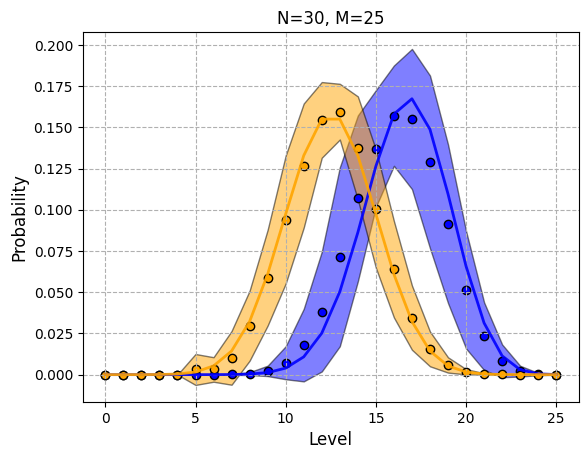

In [13]:
FourierStats.plot_several(fourier_stats_samples)
plt.title(f'N={num_qubits}, M={num_paulis}');

In [22]:
prob = 1

In [26]:
prob /= 2

In [29]:
not False and False

False

In [31]:
not (False and False)

True

In [27]:
prob

0.25

In [16]:
1.a/2

0.5

# Jax test

In [412]:
num_qubits = 20
num_samples = 10**6

random_paulis = [random_pauli(num_qubits, s) for s in range(num_samples)]
np_paulis = [(p.z, p.x) for p in random_paulis]

In [434]:
%%time

commutes = []
for pauli in random_paulis:
    commutes.append(pauli.commutes(random_paulis[0]))

CPU times: user 14.6 s, sys: 7.79 ms, total: 14.6 s
Wall time: 14.6 s


In [432]:
def np_commutes(p1, p2):
    z1, x1 = p1
    z2, x2 = p2
    symplectic_product = np.logical_xor(z1*x2, z2*x1)
    
    return np.count_nonzero(symplectic_product) % 2 == 0

In [435]:
%%time

n_commutes = []
for pauli in np_paulis:
    n_commutes.append(np_commutes(pauli, jax_paulis[0]))

CPU times: user 25.3 s, sys: 3.85 ms, total: 25.3 s
Wall time: 25.4 s


In [436]:
commutes==n_commutes

True

In [437]:
@jit
def jax_commutes(p1, p2):
    z1, x1 = p1
    z2, x2 = p2
    symplectic_product = jnp.logical_xor(z1*x2, z2*x1)
    
    return jnp.count_nonzero(symplectic_product) % 2 == 0

In [440]:
%%time

j_commutes = []
for pauli in np_paulis:
    j_commutes.append(jax_commutes(pauli, np_paulis[0]))

CPU times: user 10.1 s, sys: 272 ms, total: 10.4 s
Wall time: 10.4 s


In [ ]:
%%time

j_commutes = vmap(lambda p: jax_commutes(p, np_paulis[0]))(np_paulis)

In [441]:
commutes==j_commutes

True

# Pointwise convergence

In [126]:
def monomial(x, power):
    return jnp.product(jnp.cos(x) ** (1 - power) * jnp.sin(x) ** power)

@partial(jit, static_argnums=1)
def node_monomial(all_x, node):
    indices, powers = zip(*node.branch_history)
    indices = np.array([indices])
    powers = np.array(powers)
    x = all_x[indices]
    return monomial(x, powers)

def nodes_contribution(all_x, nodes):
    indices_and_powers = [zip(*node.branch_history) for node in nodes]
    x_and_powers = [(jnp.take(all_x, np.array(i)), p) for i, p in indices_and_powers]
    x_and_powers = jnp.array(x_and_powers)
    return vmap(lambda xp: monomial(*xp))(x_and_powers)

def fourier_level_contribution(x, level, fourier_computation):
    nodes_at_level = [node for node in fourier_computation.complete_nodes if node.level==level and node.expectation_value != 0]
    expectation_values = jnp.array([node.expectation_value for node in nodes_at_level])
    if not nodes_at_level:
        return 0
    return (expectation_values*nodes_contribution(x, nodes_at_level)).sum()

In [250]:
num_qubits = 5
num_paulis = 30

fourier_computation = FourierComputation.random(num_qubits, num_paulis, seed=0)
fourier_computation.run()

 90%|██████████████████████████████████████████▎    | 27/30 [00:41<00:04,  1.53s/it, (covered: 100.00%, relative: 100.00%, absolute: 0.031, remaining: 0)]


In [251]:
def plot_contributions_by_level(fourier_computation, num_samples):
    M = fourier_computation.pauli_circuit.num_paulis
    
    stats = []
    for s in range(num_samples):
        x = 2*jnp.pi*random.uniform(random.PRNGKey(s), (M,))
                
        level_contributions = []
        for level in range(M+1):
            level_contribution = fourier_level_contribution(x, level, fourier_computation)
            level_contributions.append(level_contribution)
        
        stats.append(level_contributions)
        
    stats = np.array(stats)
    exact_losses = stats.sum(axis=1, keepdims=True)
    absolute_contributions = np.abs(stats)
    mean_absolute_contributions = np.mean(absolute_contributions, axis=0)
    
    cumulative_contributions = np.array([[sum(contributions[:level]) for level in range(M+1)] for contributions in stats])
    accuracies = np.abs(cumulative_contributions-exact_losses)/np.abs(exact_losses)
    mean_accuracies = np.mean(accuracies, axis=0)
    
    plt.scatter(range(M + 1), mean_absolute_contributions, label='contribs');
    plt.scatter(range(M + 1), mean_accuracies, label='accuracies');
    
    plt.legend()

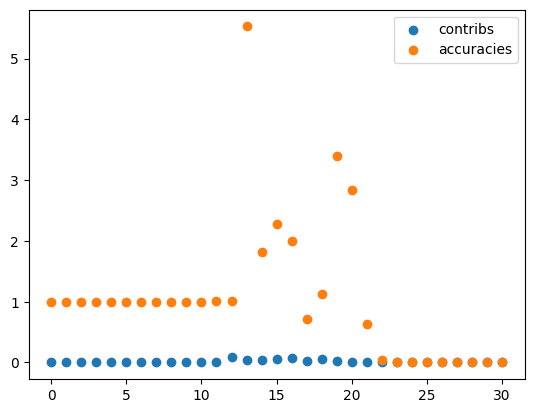

In [254]:
plot_contributions_by_level(fourier_computation, 10);

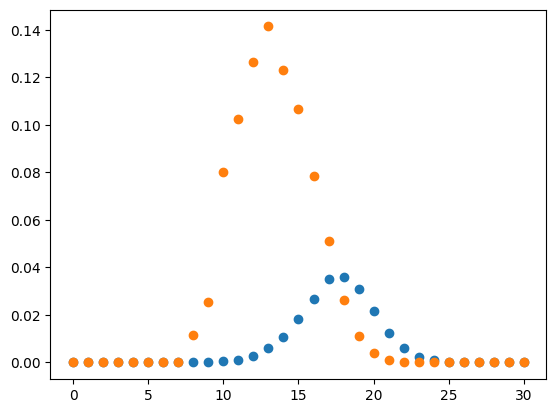

In [255]:
fourier_computation.visualize()

In [263]:
sum(nnorm)

1.0

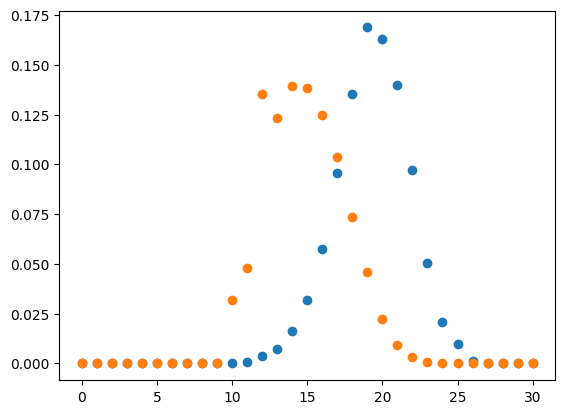

In [264]:
M = fourier_computation.pauli_circuit.num_paulis
nnorm = fourier_computation.norm_stats(only_nonzero=True)
nnorm = np.array(nnorm)/sum(nnorm)
nnode = fourier_computation.node_stats(only_nonzero=True)
nnode = np.array(nnode)/sum(nnode)
plt.scatter(range(M+1), nnode)
plt.scatter(range(M+1), nnorm)

In [261]:



def monomial_array(order, p):
    return vmap(partial(monomial, p))()


def all_monomial_arrays(all_parameters, num_parameters, order):
    parameter_configurations = list(CliffordPhiVQA.parameter_configurations(num_parameters, order))
    parameter_tuples = all_parameters[jnp.array(parameter_configurations)]
    return vmap(partial(monomial_array, order))(parameter_tuples)

In [4]:
num_qubits = 20
degree = 3
level = 3


graph = nx.random_regular_graph(degree, num_qubits, seed=41)
qaoa = QAOA(graph, level)

qc = qaoa.circuit()
observables = qaoa.observables()

pauli_circuit = PauliCircuit.from_parameterized_circuit(qc)

print(f'num paulis {pauli_circuit.num_paulis}')
fourier_computation = FourierComputation(pauli_circuit, observables[2])
fourier_computation.run()

num paulis 150


 15%|██████▌                                      | 22/150 [16:49<1:37:54, 45.90s/it, (covered: 58.78%, relative: 0.99%, absolute: 0.003, remaining: 0.3)]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_conjecture/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_53076/3802340709.py", line 16, in <module>
    fourier_computation.run()
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_conjecture/fourier_vqa.py", line 424, in run
    self.incomplete_nodes, self.complete_nodes, check_admissible)
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_conjecture/fourier_vqa.py", line 438, in iteration
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_conjecture/fourier_vqa.py", line 596, in branch_and_refine
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_conjecture/fourier_vqa.py", line 523, in remove_commuting_paulis
    num_commuting += 1
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_c

# Plotting

In [11]:
def plot_node_stats(all_node_samples, plot_random=True, num_qubits=-1, max_level=None):
    
    num_samples = len(all_node_samples)
    M = len(all_node_samples[0]) - 1
        
    c_node = 'blue'
    c_norm = 'orange'

    if plot_random:
        plt.plot(range(M + 1), random_node_distribution(M), color=c_node, linewidth=2, alpha=0.9, label='random node distribution')
        plt.plot(range(M + 1), random_norm_distribution(M), color=c_norm, linewidth=2, alpha=0.9, label='random norm distribution')

    if not max_level:
        max_level = M
    
    norm_samples = all_node_samples * 2. ** (-np.arange(M + 1))
    normilized_node_samples = all_node_samples/all_node_samples.sum(axis=1, keepdims=True)
    
    node_means = np.mean(normilized_node_samples, axis=0)[:max_level+1]
    node_variations = np.std(normilized_node_samples, axis=0)[:max_level+1]
    
    norm_means = np.mean(norm_samples, axis=0)[:max_level+1]
    norm_variations = np.std(norm_samples, axis=0)[:max_level+1]

    
    plt.fill_between(range(max_level + 1), node_means - node_variations, node_means + node_variations, alpha=0.5,
                     color=c_node, edgecolors='black', label='node variance');
    plt.fill_between(range(max_level + 1), norm_means - norm_variations, norm_means + norm_variations, alpha=0.5,
                     color=c_norm, edgecolors='black', label='norm variance');
    
    plt.scatter(range(max_level + 1), node_means, color=c_node, edgecolors='black', label='node distribution');
    plt.scatter(range(max_level + 1), norm_means, color=c_norm, edgecolors='black', label='norm distribution');

    plt.grid(linestyle='--')
    plt.ylabel('Probability', fontsize=12)
    plt.xlabel('Level', fontsize=12)
#     plt.title(f'num_qubits={num_qubits}, num_paulis={M}, num_samples={num_samples}')
    plt.legend()

# Random circuits

## Level statistics for fully random circuits

In [61]:
np.random.seed(1)

num_qubits = 5
num_paulis = 27
num_samples = 10

pauli_seeds = np.random.randint(0, 2**32-1, (num_samples, num_paulis))
observable_seeds = np.random.randint(0, 2**32-1, num_samples)

paulis = [[random_pauli(num_qubits, seed) for seed in seeds_row] for seeds_row in pauli_seeds]
observables = [random_pauli(num_qubits, seed) for seed in observable_seeds]

pauli_circuits = [PauliCircuit(p) for p in paulis]
fourier_computations = [FourierComputation(pauli_circuit, observable) for pauli_circuit, observable in zip(pauli_circuits, observables)]

for fourier_computation in tqdm(fourier_computations):
    fourier_computation.run(check_admissible=False, verbose=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:26<00:00,  8.60s/it]


In [69]:
50/np.log2(3/2)

85.47556456757273

In [68]:
1/np.log10(1.5**(1/np.log2(3/2)-1))

8.003922779651095

In [62]:
for fc in fourier_computations:

    total_nodes = len(fc.complete_nodes)
    nonzero_nodes = len([node for node in fc.complete_nodes if node.expectation_value != 0])

    print((nonzero_nodes/total_nodes)*2**num_qubits)

0.2807017543859649
0.23927105793976491
0.2498701921156688
0.24572950948127253
0.21865635161845656
0.2399546597299929
0.23691193502514257
0.168764093984142
0.2643256310128502
0.24612471896816945


0.23427133379089454

4

In [19]:
np.random.seed(1)

num_qubits = 30
num_paulis = 25
num_samples = 20

pauli_seeds = np.random.randint(0, 2**32-1, (num_samples, num_paulis))
observable_seeds = np.random.randint(0, 2**32-1, num_samples)

paulis = [[random_pauli(num_qubits, seed) for seed in seeds_row] for seeds_row in pauli_seeds]
observables = [random_pauli(num_qubits, seed) for seed in observable_seeds]

pauli_circuits = [PauliCircuit(p) for p in paulis]
fourier_computations = [FourierComputation(pauli_circuit, observable) for pauli_circuit, observable in zip(pauli_circuits, observables)]

for fourier_computation in tqdm(fourier_computations):
    fourier_computation.run(check_admissible=False, verbose=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:22<00:00,  4.13s/it]


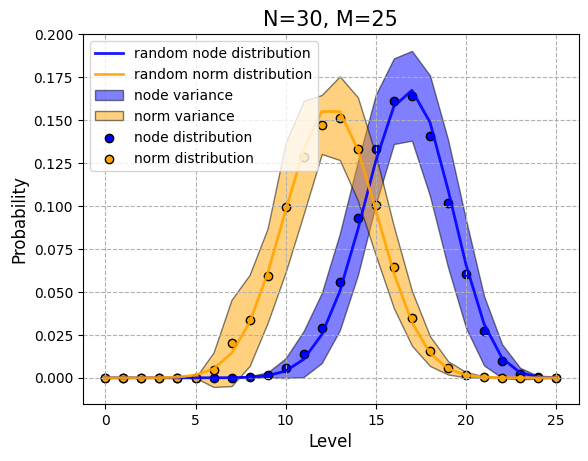

In [24]:
all_node_samples = np.array([fourier_computation.node_stats() for fourier_computation in fourier_computations])    
plot_node_stats(all_node_samples, plot_random=True)
plt.title(f'N={num_qubits}, M={num_paulis}', fontsize=15);
plt.savefig('tex/figures/random.png')

## Level statistics for local circuits with random observables

In [25]:
np.random.seed(1)

num_samples = 20
num_qubits = 6
degree = 3
level = 2

qaoa_seeds = np.random.randint(0, 2**32, num_samples)
observable_seeds = np.random.randint(0, 2**32, num_samples)

graphs = [nx.random_regular_graph(degree, num_qubits, seed=int(seed)) for seed in qaoa_seeds]
qaoa_circuits = [PauliCircuit.from_parameterized_circuit(QAOA(graph, level).circuit()) for graph in graphs]
observables = [random_pauli(num_qubits, seed) for seed in observable_seeds]
fourier_computations = [FourierComputation(circuit, observable) for circuit, observable in zip(qaoa_circuits, observables)]

for fourier_computation in tqdm(fourier_computations):
    fourier_computation.run(check_admissible=False, verbose=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [13:27<00:00, 40.38s/it]


In [26]:
all_node_samples = np.array([fourier_computation.node_stats(only_nonzero=True) for fourier_computation in fourier_computations])    
plot_node_stats(all_node_samples, plot_random=True)

KeyboardInterrupt: 

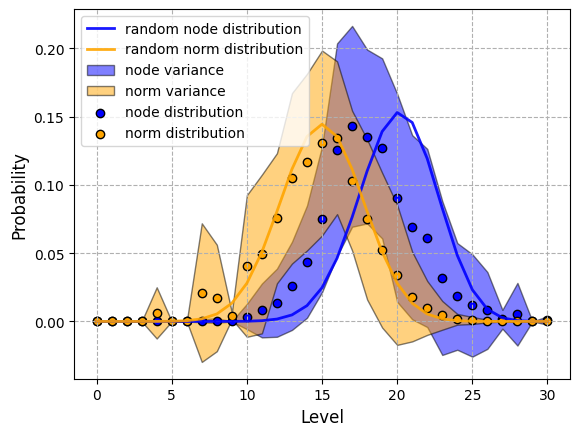

In [27]:
all_node_samples = np.array([fourier_computation.node_stats(only_nonzero=False) for fourier_computation in fourier_computations])    
plot_node_stats(all_node_samples, plot_random=True)

In [13]:
np.random.seed(42)

num_samples = 20
num_qubits = 10
num_paulis = 25
weigth = 2

circuit_seeds = np.random.randint(0, 2**32, num_samples)
observable_seeds = np.random.randint(0, 2**32, num_samples)

circuits = [random_local_pauli_circuit(num_qubits, num_paulis, weigth, seed) for seed in circuit_seeds]
observables = [random_pauli(num_qubits, seed) for seed in observable_seeds]
fourier_computations = [FourierComputation(circuit, observable) for circuit, observable in zip(circuits, observables)]

for fourier_computation in tqdm(fourier_computations):
    fourier_computation.run(check_admissible=False, verbose=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.64s/it]


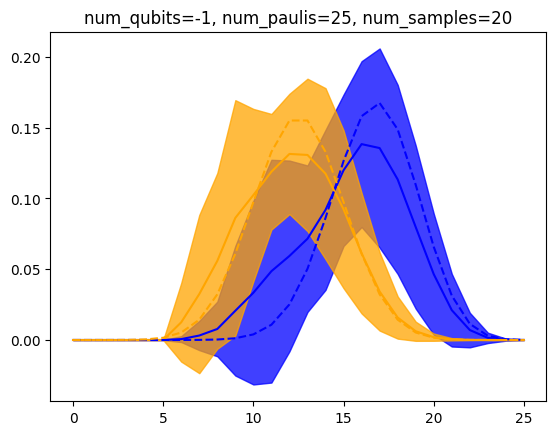

In [14]:
all_node_samples = np.array([fourier_computation.node_stats() for fourier_computation in fourier_computations])    
plot_node_stats(all_node_samples, plot_random=True)

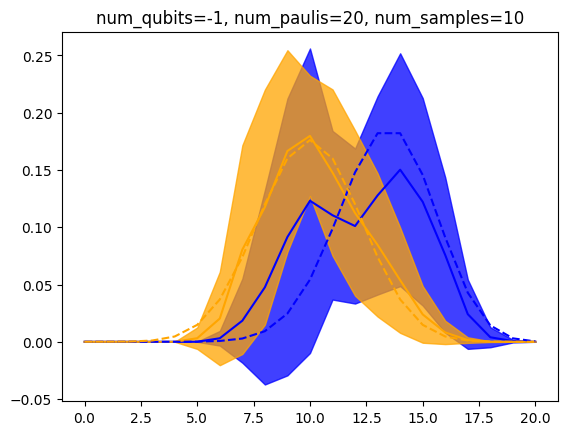

In [11]:
all_node_samples = np.array([fourier_computation.node_stats() for fourier_computation in fourier_computations])    
plot_node_stats(all_node_samples, plot_random=True)

# Hardware-efficient circuits

In [50]:
Pauli('III').compose(Pauli('X'), qargs=[0])

Pauli('IIX')

In [43]:
a


4

In [38]:
np.logical_or(p.z, p.x)

array([ True,  True,  True, False,  True])

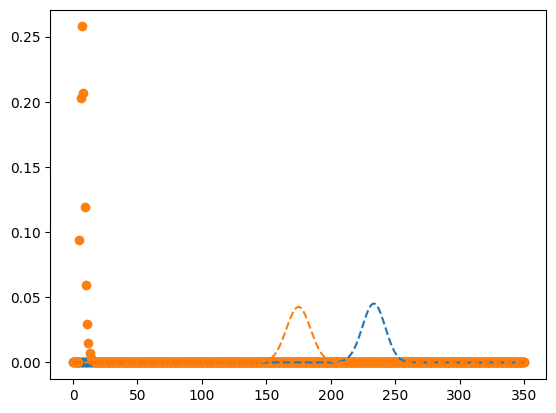

In [60]:
fourier_computation.visualize()

# QAOA

# Estimating the number of parameters

In [13]:
np.random.seed(0)
rnd.seed(42)

num_samples = 20

num_qubits = 50
degree = 3
level = 2

graph_seeds = np.random.randint(0, 2**32, num_samples)

graphs = [nx.random_regular_graph(degree, num_qubits, int(seed)) for seed in graph_seeds]
qaoas = [QAOA(graph, level) for graph in graphs]
pauli_circuits = [PauliCircuit.from_parameterized_circuit(qaoa.circuit()) for qaoa in qaoas]
observables = [rnd.choice(qaoa.observables(), ) for qaoa in qaoas]

fourier_computations = [FourierComputation(pauli_circuit, observable) for pauli_circuit, observable in zip(pauli_circuits, observables)]

for fourier_computation in tqdm(fourier_computations):
    fourier_computation.run(check_admissible=True, verbose=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:37<00:00,  7.85s/it]


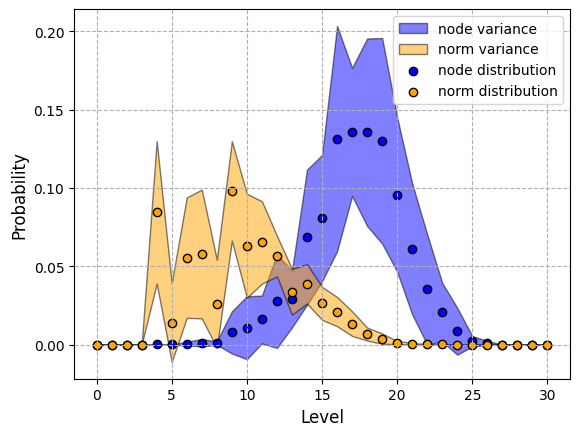

In [14]:
all_node_samples = np.array([fourier_computation.node_stats() for fourier_computation in fourier_computations])    
plot_node_stats(all_node_samples, plot_random=False, max_level=30)

## Truncated experiments

In [31]:
num_qubits = 30
degree = 3
level = 2


graph = nx.random_regular_graph(degree, num_qubits, seed=41)
qaoa = QAOA(graph, level)

qc = qaoa.circuit()
observables = qaoa.observables()

pauli_circuit = PauliCircuit.from_parameterized_circuit(qc)

num_z_paulis = int((len(pauli_circuit.paulis)-2*num_qubits)/2)
z_paulis = pauli_circuit.paulis[:num_z_paulis]

pauli_circuit_truncated = PauliCircuit(pauli_circuit.paulis[num_z_paulis:])
fourier_computation_truncated = FourierComputation(pauli_circuit_truncated, observables[0])

print(len(pauli_circuit_truncated.paulis))
    
fourier_computation_truncated.run(check_admissible=False)

143


cov 100.00% abs 0.0017 rel 100.00% rem 0 nodes 0.00e+00 vol 0.00e+00:  20%|█████████                                     | 28/143 [06:17<25:49, 13.47s/it]


In [41]:
z_paulis = pauli_circuit.paulis[:num_z_paulis]

commute_list = []
for node in tqdm(fourier_computation_truncated.complete_nodes[:100000]):
    node_commutes = [node.observable.commutes(z_p) for z_p in z_paulis]
    commute_list.append(sum(node_commutes))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:54<00:00, 871.90it/s]


In [44]:
len(z_paulis)

82

In [45]:
sorted(commute_list)

[57,
 57,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,


In [37]:
len([node for node in fourier_computation_truncated.complete_nodes if node.expectation_value ==0])

694699

In [99]:
num_z_paulis = int((len(pauli_circuit.paulis)-2*num_qubits)/2)
z_paulis = pauli_circuit.paulis[:num_z_paulis]

commute_list = []
for node in tqdm(fourier_computation.complete_nodes[:10000]):
    node_commutes = [node.observable.commutes(z_p) for z_p in z_paulis]
    commute_list.append(sum(node_commutes))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1520.87it/s]


In [106]:
x_list = []
for node in tqdm(fourier_computation.complete_nodes[:10000]):
    node_x_factor = sum(node.observable.z)
    x_list.append(node_x_factor)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 78826.08it/s]


In [110]:
2**5

32

In [109]:
sorted(x_list)[::-1]

[5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


In [103]:
sorted(commute_list)

[37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,


In [92]:
pauli_circuit.paulis[44:57]

[Pauli('IIXIIIIIIIXIIIIIIIIIIIIIIIIIII'),
 Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ'),
 Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIZI'),
 Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIZII'),
 Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIZIII'),
 Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIZIIII'),
 Pauli('IIIIIIIIIIIIIIIIIIIIIIIIZIIIII'),
 Pauli('IIIIIIIIIIIIIIIIIIIIIIIZIIIIII'),
 Pauli('IIIIIIIIIIIIIIIIIIIIIIZIIIIIII'),
 Pauli('IIIIIIIIIIIIIIIIIIIIIZIIIIIIII'),
 Pauli('IIIIIIIIIIIIIIIIIIIIZIIIIIIIII'),
 Pauli('IIIIIIIIIIIIIIIIIIIZIIIIIIIIII'),
 Pauli('IIIIIIIIIIIIIIIIIIZIIIIIIIIIII')]

In [15]:
num_qubits = 20
degree = 2
level = 2


graph = nx.random_regular_graph(degree, num_qubits, seed=41)
qaoa = QAOA(graph, level)

qc = qaoa.circuit()
observables = qaoa.observables()

pauli_circuit = PauliCircuit.from_parameterized_circuit(qc)

print(len(pauli_circuit.paulis))
print(len(observables))

for observable in observables[:5]:
    fourier_computation = FourierComputation(pauli_circuit, observable)
    fourier_computation.run(check_admissible=False)
    exact_nodes = len(fourier_computation.complete_nodes)
    est_nodes = fourier_computation.estimate_node_count(num_samples=1000)
    print(f'exact {exact_nodes} estimated {est_nodes} percentage {est_nodes/exact_nodes:2%}')

80
20


cov 100.00% abs 0 rel 100.00% rem 0 nodes 0.00e+00 vol 0.00e+00:  24%|████████████▎                                       | 19/80 [00:02<00:07,  8.41it/s]


AttributeError: 'FourierComputation' object has no attribute 'estimate_node_count'

In [ ]:
%%prun -s tot

num_qubits = 20
degree = 3
level = 3


graph = nx.random_regular_graph(degree, num_qubits, seed=41)
qaoa = QAOA(graph, level)

qc = qaoa.circuit()
observables = qaoa.observables()

pauli_circuit = PauliCircuit.from_parameterized_circuit(qc)

print(f'num paulis {pauli_circuit.num_paulis}')
# pauli_circuit.paulis = pauli_circuit.paulis[num_qubits:]

fourier_computation = FourierComputation(pauli_circuit, observables[0])
fourier_computation.run()

num paulis 150


cov 95.45% abs 0.011 rel 28.67% rem 0.027 nodes 3.56e+06 vol 7.11e+07:  18%|███████▍                                 | 27/150 [31:18<11:18:37, 331.04s/it]

In [ ]:
num_qubits = 20
degree = 3
level = 3


graph = nx.random_regular_graph(degree, num_qubits, seed=41)
qaoa = QAOA(graph, level)

qc = qaoa.circuit()
observables = qaoa.observables()

pauli_circuit = PauliCircuit.from_parameterized_circuit(qc)

print(f'num paulis {pauli_circuit.num_paulis}')
# pauli_circuit.paulis = pauli_circuit.paulis[num_qubits:]

fourier_computation = FourierComputation(pauli_circuit, observables[0])
fourier_computation.run()

num paulis 150


 19%|██████████▍                                             | 28/150 [1:15:43<28:15:09, 833.68s/it, (relative: 61.12%, absolute: 0.03, remaining: 0.019)]

In [18]:
num_qubits = 50
degree = 3
level = 4


graph = nx.random_regular_graph(degree, num_qubits, seed=41)
qaoa = QAOA(graph, level)

qc = qaoa.circuit()
observables = qaoa.observables()

pauli_circuit = PauliCircuit.from_parameterized_circuit(qc)

print(f'num paulis {pauli_circuit.num_paulis}')
pauli_circuit.paulis = pauli_circuit.paulis[num_qubits:]


fourier_computation = FourierComputation(pauli_circuit, observables[2])

for observable in observables[:5]:
    fourier_computation = FourierComputation(pauli_circuit, observable)
    print('='*10)
    
    volume_stats = fourier_computation.estimate_node_count_limited_volume(max_nodes=1000)
    mc_stats = fourier_computation.estimate_node_count_monte_carlo(num_samples=1000)

    volume_tot = volume_stats.sum()
    mc_tot = mc_stats.sum()

    print(f'vol {volume_tot:.2e} mc {mc_tot:.2e} ratio {volume_tot/mc_tot:.2%}')

num paulis 500


 14%|████████████████▍                                                                                                   | 64/450 [00:41<04:12,  1.53it/s]


vol 4.05e+15 mc 9.82e+15 ratio 41.21%


 16%|██████████████████▌                                                                                                 | 72/450 [00:47<04:08,  1.52it/s]


vol 1.52e+18 mc 1.20e+17 ratio 1260.25%


 14%|████████████████▍                                                                                                   | 64/450 [00:39<03:59,  1.61it/s]


vol 3.89e+15 mc 6.55e+16 ratio 5.94%


 15%|█████████████████                                                                                                   | 66/450 [00:43<04:10,  1.53it/s]


vol 8.85e+15 mc 1.71e+13 ratio 51842.77%


 17%|███████████████████▌                                                                                                | 76/450 [00:45<03:45,  1.66it/s]


vol 5.30e+18 mc 1.51e+20 ratio 3.50%


Example.

## Pushing N to the limit

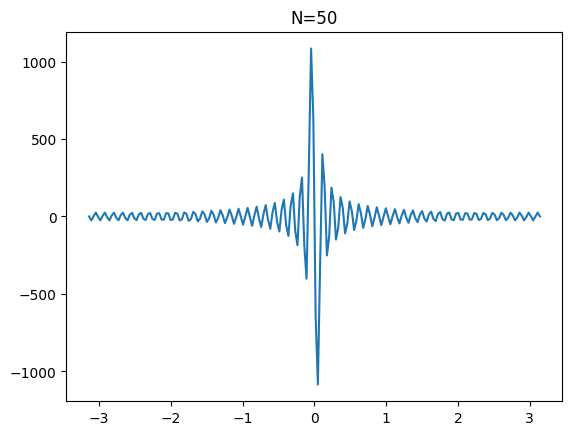

In [38]:
x = np.linspace(-np.pi, np.pi, 200)

def vals(N):
    return -sum([np.cos(n*x) for n in range(N+1)])

def grads(N):
    return -sum([n*np.sin(n*x) for n in range(N+1)])

# for N in [1, 4, 10, 30]:
N=50
plt.plot(x, grads(N))
plt.title(f'N={N}')
plt.savefig(f'results/N={N}.png')